**<h1>IMPORT LIBRARIES</h1>**

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**<h1>DATASET PREPARATION</h1>**

In [2]:
csv_path = './poster_labeled.csv'
images_dir = './Images/'
output_dir = './Images/Processed Images/'

In [3]:
data = pd.read_csv(csv_path)

In [4]:
def resize_to_fixed_size(image, target_width=300, target_height=425):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    if aspect_ratio > (target_width / target_height):
        new_w = target_width
        new_h = int(target_width / aspect_ratio)
    else:
        new_h = target_height
        new_w = int(target_height * aspect_ratio)

    resized = cv2.resize(image, (new_w, new_h))

    delta_w = target_width - new_w
    delta_h = target_height - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

In [5]:
def process_images(data, images_dir, output_dir, target_width=300, target_height=425):
    os.makedirs(output_dir, exist_ok=True)
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        img_filename = f"{row['Id']}.jpg"
        img_path = os.path.join(images_dir, img_filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            processed_img = resize_to_fixed_size(img, target_width, target_height)
            output_path = os.path.join(output_dir, img_filename)
            cv2.imwrite(output_path, processed_img)
        else:
            print(f"Image not found: {img_path}")

In [6]:
process_images(data, images_dir, output_dir, target_width=300, target_height=425)

100%|█████████████████████████████████████████████████████████████████████████████| 7248/7248 [00:29<00:00, 247.89it/s]


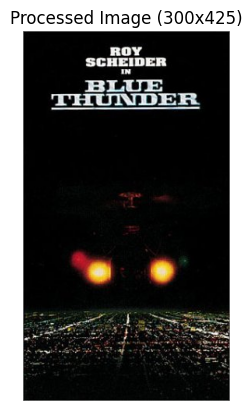

In [7]:
sample_image = cv2.imread('./Images/tt0085255.jpg')
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Processed Image (300x425)")
plt.show()

**<h1>ENCODING</h1>**

In [6]:
data['genre_list'] = data['Formatted Genre'].apply(lambda x: x.split(", ") if isinstance(x, str) else [])

In [7]:
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(data['genre_list'])

In [8]:
encoded_genres_df = pd.DataFrame(labels_encoded, columns=mlb.classes_, index=data.index)

In [9]:
data = pd.concat([data, encoded_genres_df], axis=1)

**<h1>SPLITTING DATASET</h1>**

In [10]:
def load_images(data, images_dir, target_width=300, target_height=425):
    images = []
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        img_filename = f"{row['Id']}.jpg"
        img_path = os.path.join(images_dir, img_filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            processed_img = resize_to_fixed_size(img, target_width, target_height)
            images.append(processed_img)
        else:
            print(f"Image not found: {img_path}")
    return np.array(images)

In [11]:
images = load_images(data, output_dir, target_width=300, target_height=425)

100%|█████████████████████████████████████████████████████████████████████████████| 7248/7248 [00:15<00:00, 481.15it/s]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [13]:
print(f'Training set: {len(X_train)} images')
print(f'Validation set: {len(X_val)} images')

Training set: 5798 images
Validation set: 1450 images


**<h1>TRAINING MODEL</h1>**

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(425, 300, 3))

In [15]:
base_model.trainable = False

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('./fix/poster_classification.h5', save_best_only=True, monitor='val_loss')

In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(labels_encoded.shape[1], activation='sigmoid')(x)

In [18]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=3e-6), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint,reduce_lr, early_stopping]
)

Epoch 1/50
91/91 [==============================] - 31s 168ms/step - loss: 0.6856 - accuracy: 0.2168 - val_loss: 0.6203 - val_accuracy: 0.2600 - lr: 3.0000e-06
Epoch 2/50
91/91 [==============================] - 14s 157ms/step - loss: 0.5670 - accuracy: 0.2765 - val_loss: 0.5206 - val_accuracy: 0.2931 - lr: 3.0000e-06
Epoch 3/50
91/91 [==============================] - 14s 156ms/step - loss: 0.4809 - accuracy: 0.2963 - val_loss: 0.4485 - val_accuracy: 0.3028 - lr: 3.0000e-06
Epoch 4/50
91/91 [==============================] - 15s 162ms/step - loss: 0.4189 - accuracy: 0.3017 - val_loss: 0.3969 - val_accuracy: 0.3103 - lr: 3.0000e-06
Epoch 5/50
91/91 [==============================] - 14s 158ms/step - loss: 0.3749 - accuracy: 0.3063 - val_loss: 0.3609 - val_accuracy: 0.3055 - lr: 3.0000e-06
Epoch 6/50
91/91 [==============================] - 14s 156ms/step - loss: 0.3446 - accuracy: 0.3084 - val_loss: 0.3365 - val_accuracy: 0.3000 - lr: 3.0000e-06
Epoch 7/50
91/91 [======================

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 425, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 213, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 213, 150, 32  128         ['Conv1[0][0]']                  
                                )                                                             

**<h1>LOAD MODEL</h1>**

In [ ]:
model = load_model('./fix/poster_classification.h5')

**<h1>MINI TESTING</h1>**

**<h1>DATASET PREPARATION</h1>**

In [21]:
test_image = cv2.imread('./Images/Testing/lovely-man.jpg')
test_image = resize_to_fixed_size(test_image, target_width=300, target_height=425)
test_image = np.expand_dims(test_image, axis=0)
test_image = preprocess_input(test_image)

predictions = model.predict(test_image)

1/1 [==============================] - 1s 666ms/step


In [22]:
val_predictions = model.predict(X_val)
predicted_genres = mlb.inverse_transform(val_predictions > 0.2)
print(predicted_genres[:1])

46/46 [==============================] - 3s 60ms/step
[('comedy', 'drama')]
